In [1]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

### 现有指标：
+ 均线 
+ 布林带
+ MACD柱状图
+ RSI相对强弱
+ WilliamR指标

In [103]:
class Strategy_lite1(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('p_stake', 100),

        # Indicator params
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
        ('wave_period', 7),
        
        # ATR params
        ('using_atr', False),
        ('atr_period', 14),
        ('atr_percent', 1),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Keep references to lines in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # Keep references to executed order & price
        self.buyprice = 0
        self.sellprice = 0
        self.order = None

        # Add indicators
        ## Bollinger Bands indicator
        self.bolling = bt.indicators.BollingerBands(self.datas[0], 
                                                    period = self.params.bollinger_per, 
                                                    devfactor = self.params.bollinger_dev)
        self.bolling_buy = bt.Or(bt.And(self.dataclose(0) > self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1)), 
                                 bt.And(self.dataclose(0) > self.bolling.bot(0), self.dataclose(-1) < self.bolling.bot(-1)))
        self.bolling_sell = bt.Or(bt.And(self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) > self.bolling.top(-1)), 
                                  bt.And(self.dataclose(0) < self.bolling.bot(0), self.dataclose(-1) > self.bolling.bot(-1)))

        ## ATR indicator
        self.atr_initial = self.broker.get_cash()
        self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
                                    abs(self.dataclose(-1) - self.datahigh),
                                    abs(self.dataclose(-1) - self.datalow))
        self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)

        ## Wave indicator
        ### MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.wave_period)
        #self.wave_buy = bt.Or(bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3)),
        #                                        bt.And(self.sma(0) > self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3), 
        #                                                     self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1), self.dataclose(-2) < self.bolling.top(-2)))
        self.wave_buy = bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3), self.sma(0) > self.bolling.mid(0))
        self.wave_sell = bt.And(self.sma(0) < self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3))


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.log('BUY EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash()))

            else:  # Sell
                self.sellprice = order.executed.price
                self.log('SELL EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash()))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        buy_indicator = self.wave_buy and self.dataclose[0] > self.bolling.mid[0]
        sell_indicator = self.bolling_sell or self.wave_sell
            
        if buy_indicator and self.getposition(self.data).size == 0:
            if self.params.using_atr:
                opt_pos = np.round(self.atr_initial * self.params.atr_percent / self.params.p_stake / self.atr[0])
                if opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size < opt_pos*self.params.p_stake:
                    self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                             (self.dataclose[0], 
                             opt_pos*self.params.p_stake-self.getposition(self.data).size,
                             self.getposition(self.data).size))
                    self.buy(size=opt_pos*self.params.p_stake-self.getposition(self.data).size)
            else:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        self.params.p_stake,
                        self.getposition(self.data).size))
                self.buy(size=self.params.p_stake)
        elif sell_indicator and self.getposition(self.data).size > 0:
            self.log('Sell CREATE(Close), Price: %.2f, Current Position: %i' % (self.dataclose[0],
                        self.getposition(self.data).size))
            self.close()


    def stop(self):
        self.log('Ending Position:%i. Ending Value:%.2f.' %
                (self.getposition(self.data).size,
                self.cerebro.broker.getvalue()), doprint=False)

### 沪深300回测

In [62]:
s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
e_date = datetime.date(2020,12,31)
idx = '399300.SZ'
pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
index_list = np.unique(pro.index_weight(index_code=idx,
                                        start_date=s_date.strftime('%Y%m%d'),
                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()


profit_stk = dict()
for stk in index_list:
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_lite1, printlog=False, using_atr=True, atr_percent=0.01) 

    # Create stock Data Feed
    #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
    #                    stock_index, s_date, e_date)
    df = pd.read_csv('.\\Data\\2019\\'+stk+'.csv', 
                        converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)

    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(500000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('%s, Net Profit: %.2f%%' % (stk, (final_value - start_value) / start_value * 100))

    profit_stk[stk] = (final_value - start_value) / start_value * 100

000001.SZ, Net Profit: 13.76%
000002.SZ, Net Profit: 7.20%
000063.SZ, Net Profit: 0.98%
000066.SZ, Net Profit: -2.41%
000069.SZ, Net Profit: 6.09%
000100.SZ, Net Profit: 0.08%
000157.SZ, Net Profit: 0.91%
000166.SZ, Net Profit: 0.33%
000333.SZ, Net Profit: 2.41%
000338.SZ, Net Profit: 5.91%
000413.SZ, Net Profit: 10.30%
000415.SZ, Net Profit: -6.94%
000423.SZ, Net Profit: -3.66%
000425.SZ, Net Profit: 3.76%


KeyboardInterrupt: 

# 单股回测

In [104]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_lite1, printlog=True, using_atr=True, atr_percent=0.01) 

    s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
    e_date = datetime.date(2020,12,31)

    # Create stock Data Feed
    stock_index = '000066.SZ'
    #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
    #                    stock_index, s_date, e_date)
    df = pd.read_csv('.\\Data\\2019\\' + stock_index + '.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)

    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(20000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 20000.00
2020-06-02: BUY CREATE, Price: 14.18, Lots: 300, Current Position: 0
2020-06-03: BUY EXECUTED, Price:14.18, Lot:300, Cash:15746.
2020-06-04: Sell CREATE(Close), Price: 13.58, Current Position: 300
2020-06-05: SELL EXECUTED, Price:13.58, Lot:300, Cash:19820.
2020-06-05: OPERATION PROFIT, GROSS -180.00, NET -180.00
2020-07-24: BUY CREATE, Price: 16.01, Lots: 200, Current Position: 0
2020-07-27: BUY EXECUTED, Price:16.01, Lot:200, Cash:16618.
2020-08-05: Sell CREATE(Close), Price: 20.13, Current Position: 200
2020-08-06: SELL EXECUTED, Price:20.13, Lot:200, Cash:20644.
2020-08-06: OPERATION PROFIT, GROSS 824.00, NET 824.00
2020-12-15: BUY CREATE, Price: 15.73, Lots: 400, Current Position: 0
2020-12-16: BUY EXECUTED, Price:15.73, Lot:400, Cash:14352.
2020-12-18: Sell CREATE(Close), Price: 15.72, Current Position: 400
2020-12-21: SELL EXECUTED, Price:15.72, Lot:400, Cash:20640.
2020-12-21: OPERATION PROFIT, GROSS -4.00, NET -4.00
2020-12-31: Ending Positio

<IPython.core.display.Javascript object>


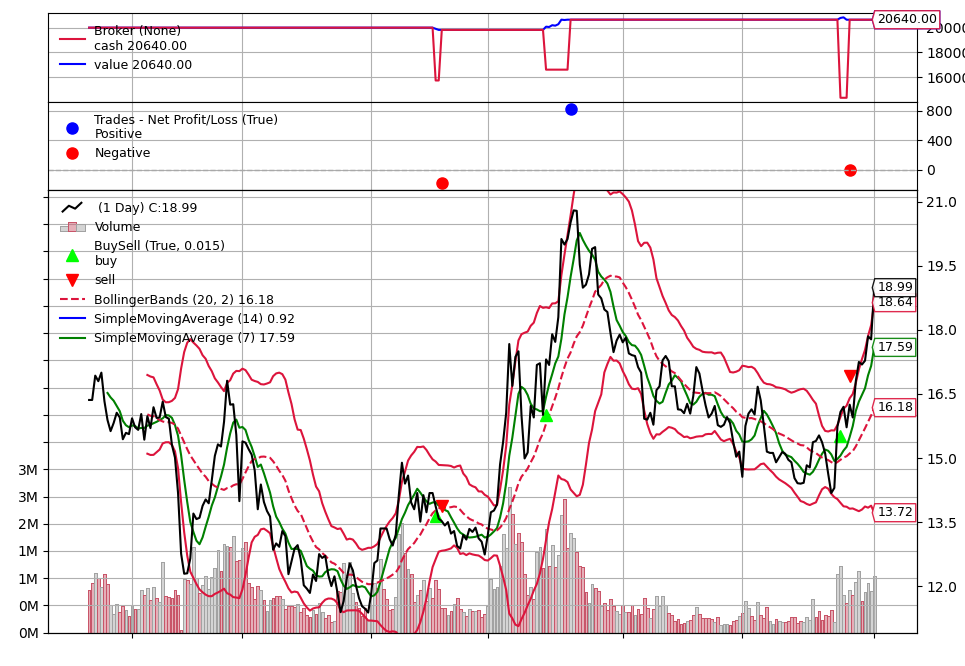

[[<Figure size 640x480 with 4 Axes>]]

In [105]:
cerebro.plot()